In [1]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoETS, AutoTheta, AutoCES)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import yfinance as yf
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [3]:
# Split data into training and testing sets
Y_train_df = Y_df[Y_df.ds <= '2023-01-01'] # Train set
Y_test_df = Y_df[Y_df.ds > '2023-01-01']   # Test set

In [4]:
season_length = 12 # Define season length as 12 months for monthly data

# Define a list of models for forecasting
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='M',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(df=Y_df)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [5]:
# Generate forecasts for the specified horizon using the sf object
horizon = 3

# Start the timer
start_time = time.time()

# Generate the forecast
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon) 

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Display the elapsed time
print(f"Time taken to generate the forecast: {elapsed_time:.4f} seconds")

# Display the first 5 rows of the forecast
Y_hat_df.head(5)

Time taken to generate the forecast: 1875.6917 seconds


,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
AAPL,2023-01-31,145.879547,144.227402,141.458527,136.738312
AAPL,2023-02-28,142.526260,145.345169,145.446671,142.126144
AAPL,2023-03-31,140.889114,146.462936,147.355850,141.644333
AMZN,2023-01-31,101.099319,103.128082,95.366661,98.909363
AMZN,2023-02-28,101.314880,103.128082,97.721832,100.288879


In [6]:
Y_hat_df = Y_hat_df.reset_index()

In [7]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate_forecast(y_true, y_pred):
    results = pd.DataFrame({
        'mae': [mean_absolute_error(y_true, y_pred)],
        'mse': [mean_squared_error(y_true, y_pred)],
        'mape': [mean_absolute_percentage_error(y_true, y_pred)],
        'rmse': [np.sqrt(mean_squared_error(y_true, y_pred))],
        'smape:': [symmetric_mean_absolute_percentage_error(y_true, y_pred)],
    })
    return results

# Evaluar múltiples modelos para múltiples tickers
evaluation_results_all_models = {}
models_to_evaluate = ['AutoARIMA', 'AutoETS', 'AutoTheta', 'CES']

for ticker in tickers:
    evaluation_results_all_models[ticker] = {}
    Y_test_true = Y_test_df[Y_test_df['unique_id'] == ticker]['y'].values[:horizon]
    for model in models_to_evaluate:
        Y_test_pred = Y_hat_df.loc[Y_hat_df['unique_id'] == ticker, model].values[:horizon]
        evaluation_results_all_models[ticker][model] = evaluate_forecast(Y_test_true, Y_test_pred)

# Imprimir resultados de evaluación para todos los modelos y tickers
for ticker, models_results in evaluation_results_all_models.items():
    print(f"Results for {ticker}:")
    for model, results in models_results.items():
        print(f"Model: {model}")
        print(results)
        print()

Results for AAPL:
Model: AutoARIMA
         mae        mse      mape       rmse     smape:
0  16.421122  405.97606  0.098744  20.148848  10.664183

Model: AutoETS
        mae         mse      mape      rmse    smape:
0  14.17426  277.479621  0.085751  16.65772  9.108694

Model: AutoTheta
         mae         mse      mape       rmse    smape:
0  14.765747  269.558623  0.090091  16.418241  9.529922

Model: CES
         mae         mse      mape       rmse     smape:
0  19.349833  427.808286  0.118905  20.683527  12.736855

Results for MSFT:
Model: AutoARIMA
         mae          mse      mape      rmse     smape:
0  38.778035  2133.288887  0.132102  46.18754  14.546231

Model: AutoETS
         mae          mse      mape       rmse     smape:
0  31.978256  1550.836019  0.108185  39.380655  11.773222

Model: AutoTheta
         mae          mse      mape       rmse    smape:
0  38.740534  1939.999595  0.133302  44.045426  14.55167

Model: CES
         mae          mse      mape       rmse 

In [8]:
cv_df = sf.cross_validation(df=Y_train_df, h=3, n_windows=3, step_size=3, level=[99])
cv_df.head()

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,
AAPL,2022-05-01,2022-04-01,146.959000,150.311310,141.382599,159.240021,155.687424,109.518486,201.856369,155.687012,147.600723,163.937836,161.012695,146.997192,174.307968
AAPL,2022-06-01,2022-04-01,135.190506,163.813904,150.259659,177.368149,155.715561,90.200943,221.230179,151.822510,140.198807,164.594025,166.471313,152.870911,180.070221
AAPL,2022-07-01,2022-04-01,160.691986,172.154419,156.465225,187.843613,155.743698,75.229103,236.258301,156.833725,142.233521,171.694916,172.286316,157.800262,186.473572
AAPL,2022-08-01,2022-07-01,155.461151,166.664032,156.465607,176.862442,162.227402,114.687904,209.766891,166.932266,158.003723,176.042450,158.605652,143.733582,173.081787
AAPL,2022-09-01,2022-07-01,136.843735,162.446121,147.938477,176.953766,163.765259,95.433434,232.097076,156.477386,144.140488,170.031494,155.537369,141.423309,170.766678


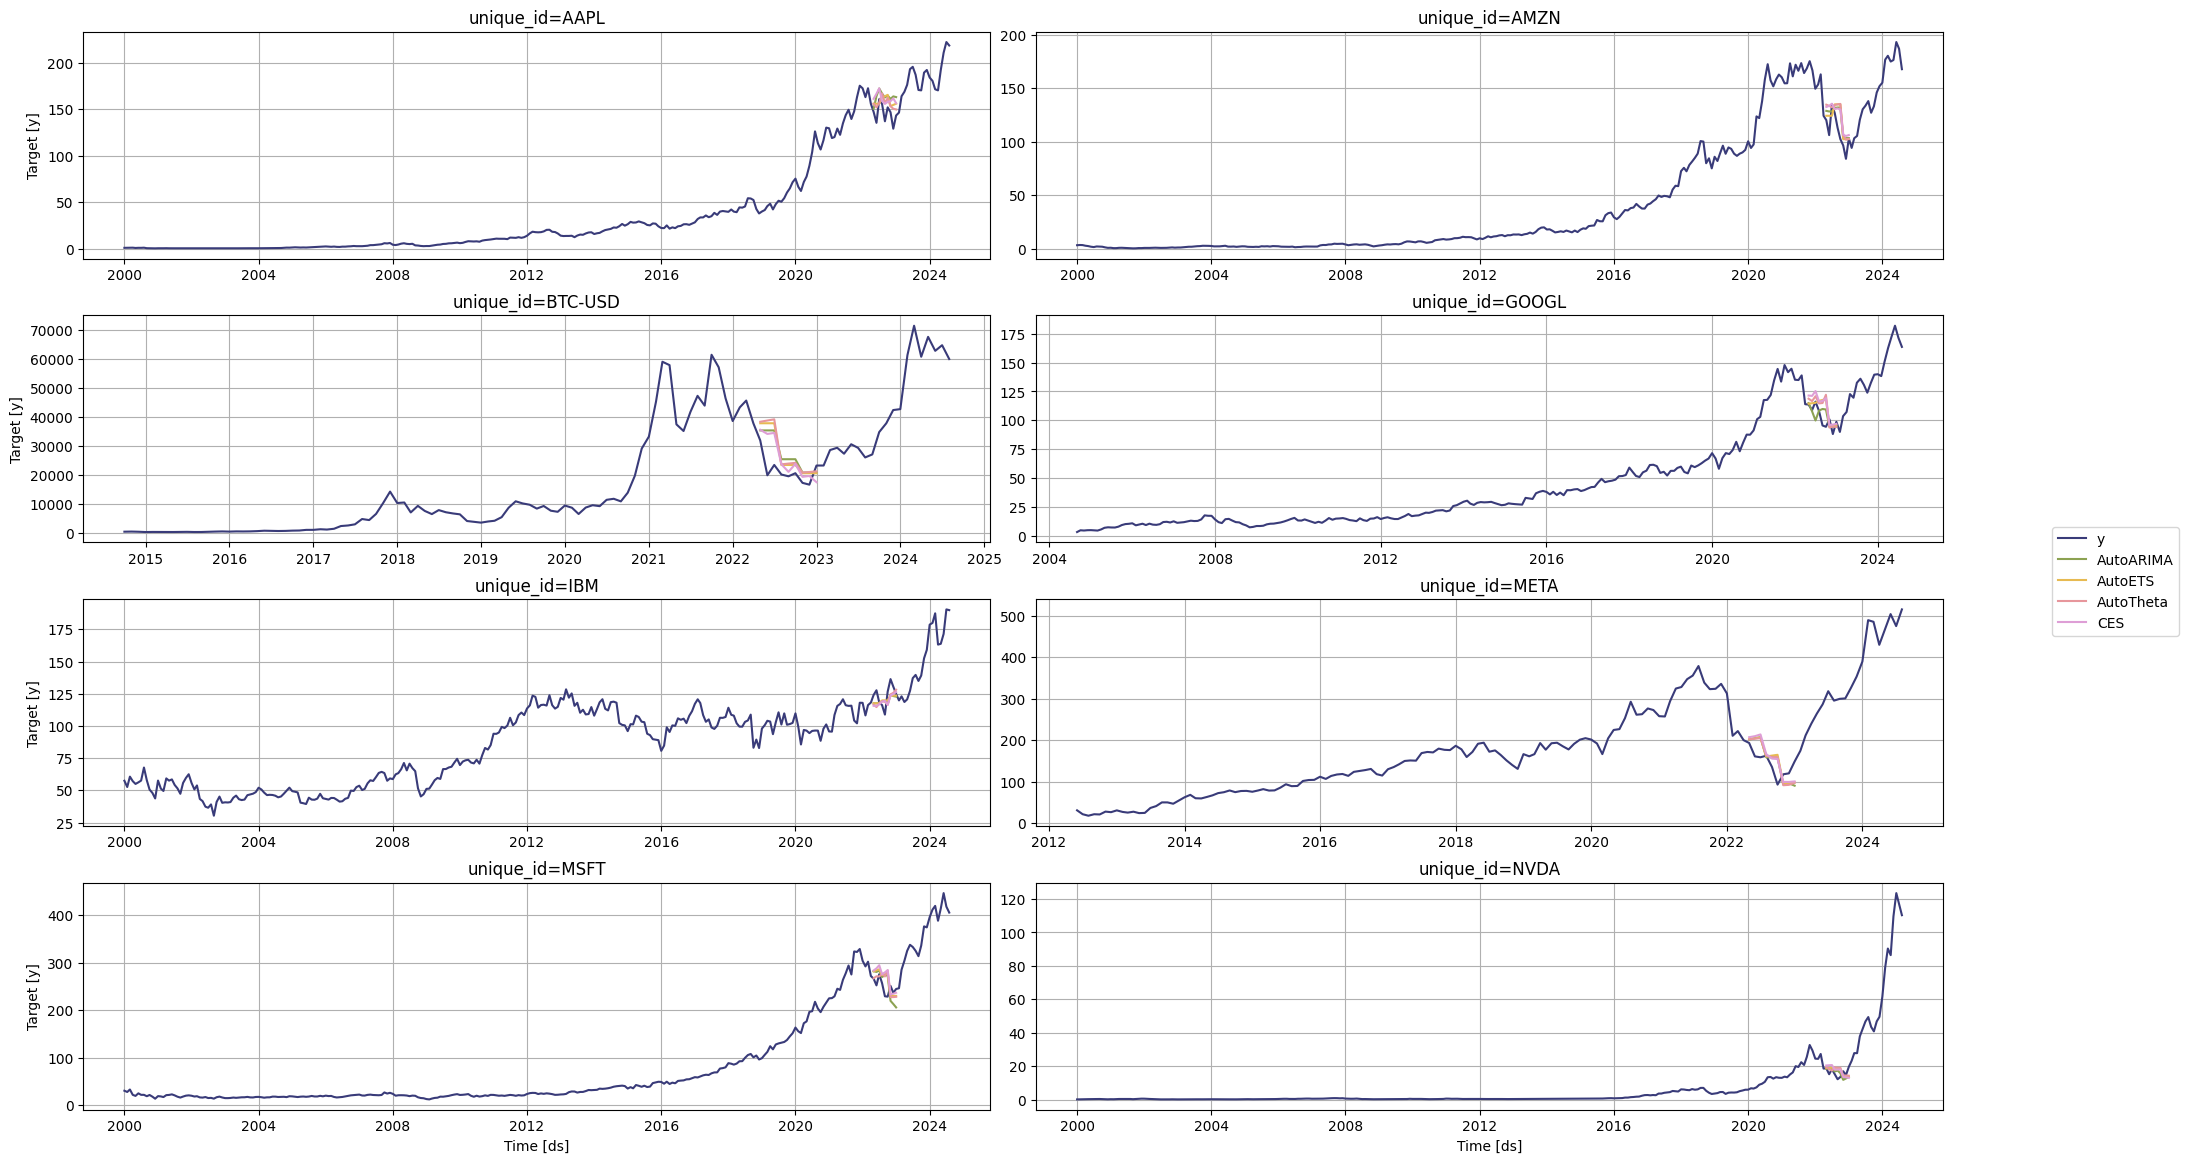

In [9]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))